In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, memoize, xr_utils, xr_transect
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb, mkanim

from stompy.grid import unstructured_grid
from matplotlib import colors, cm
import matplotlib.colorbar as cbar
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp

import stompy.plot.cmap as scmap

from numba import njit
from stompy.spatial import field
from scipy import ndimage
from scipy.optimize import minimize
import time
import six
import datetime

In [3]:
# These online-coupled dfm-dwaq runs.
import bloom_common
#six.moves.reload_module(bloom_common)
from bloom_common import load_model, ratio, chl_from_RS
import tracer_group
six.moves.reload_module(tracer_group)
from tracer_group import TracerGroup, tracer_groups

In [4]:
grid_poly = tracer_groups[0].grid.boundary_polygon()
turbo_low = scmap.cmap_transform(cm.turbo,lambda i: i**0.75)

INFO:utils:75346/86633
INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


In [5]:
def solveNP(group,
            thresh=1e-5,
            # Parameters:
            c0 = 1,
            tidx = 20, 
            Isat=20., 
            N0=35, # initial DIN
            Nsat=0.5,
            kprod=1.0, # per day assuming 24h light. so 0.5 d^-1 in typical lit.
            kmort=0.1,
            background=0.0,
            alpha=0.15, # stoichiometry, uM DIN per ug/l chl production.
            light_lim='mean_lim',
            layer=15,
            presel=None, # bitmask over cells, True to compute. False entries get nan.
            P_nodata=0.0,
            N_nodata=None, # N0
           ):
    tracers=group.extract_tracers(tidx=tidx, layer=layer, Isat=Isat, thresh=thresh, light_lim=light_lim)
    kLight = tracers['kLight']
    conc = c0*tracers['conc']
    age_d = tracers['age_d']
    t = tracers['t']

    if N_nodata is None:
        N_nodata=N0
        
    if age_d>0.0:
        sel = np.isfinite(kLight * conc * age_d)
    else:
        sel = np.isfinite(conc)

    if presel is not None:
        sel = presel & sel

    kLight = kLight[sel]

    # ODE integration
    # State vector is [ P[0].... P[i], N[0], ... , N[i] ]
    def diff(t,state):
        P,N=state.reshape([2,-1])
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        kDIN=N/(N+Nsat)
        dgrossP = kprod*kLight*kDIN*P
        dnetP = -kmort*P + dgrossP
        dN = -alpha*dgrossP
        mu_net = kprod*kLight*kDIN - kmort
        return np.r_[dnetP,dN]
    IC=np.r_[conc[sel], N0*np.ones_like(conc)[sel]]

    # print("IC shape: ", IC.shape) # 2*Ncells

    if age_d>0:
        # odeint was buggy.
        #result = odeint(diff, IC, [0,age_d], hmax=0.1)
        bunch = solve_ivp(diff, y0=IC, t_span=[0,age_d])
        result=bunch.y[:,-1]
    else:
        result = IC
    Psel,Nsel = result.reshape([2,-1])
    # expand
    # assume no biomass, no depletion of N when conc too small.
    P = np.full(conc.shape,P_nodata)
    N = np.full(conc.shape,N_nodata)
        
    P[sel]=Psel + background # or add to P?
    N[sel]=Nsel
    
    ds=xr.Dataset()
    ds['N'] = ('cell',), N
    ds['P'] = ('cell',), P
    ds['time'] = (),t

    ds['c0'] = (),c0
    ds['Isat'] = (),Isat
    ds['N0'] = (),N0
    ds['Nsat'] = (),Nsat
    ds['kprod'] = (), kprod
    ds['kmort'] = (), kmort
    ds['alpha'] = (), alpha
    ds['layer'] = (), layer
    
    return ds

In [6]:
class FigLagrangianSnapshot:
    group=None
    tidx=None
    layer=15
    thresh=1e-2 
    c0=3
    kprod=1.0 
    N0=35 # initial DIN, uM
    Nsat=0.5 # half-sat DIN, uM
    kmort=0.05
    Isat=10.0
    colorbar=True

    figsize=(11,4)
    zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)
    panels=['lagP','lagN','remoteP']
    cmap='turbo'

    N_clim=[0,40]
    chl_clim=[0,220]
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)

        t=self.group.ds.time.values[self.tidx]
        rs_chl = chl_from_RS(t,grid_poly)

        result = solveNP(group=self.group,
                         tidx=self.tidx,
                         layer=self.layer,
                         thresh=self.thresh,
                         c0=self.c0,
                         kprod=self.kprod,
                         N0=self.N0, # initial DIN, uM
                         Nsat=self.Nsat, # half-sat DIN, uM
                         kmort=self.kmort,
                         Isat=self.Isat)
        self.result=result
    
        fig,axs=plt.subplots(1,len(self.panels),figsize=self.figsize,squeeze=False)
        axs=axs[0,:]
        self.fig=fig
        self.axs=axs
        fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
        if self.colorbar:
            caxs=[cbar.make_axes(ax)[0] for ax in axs]
        else:
            caxs=[None] * len(axs)
        
        self.caxs=caxs
        kw=dict(lw=0.5,edgecolor='face')
        cmap=self.cmap
    
        for ax in axs:
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
    
        for ax,cax,panel in zip(axs,caxs,self.panels):
            if panel=='lagP':
                ccoll=self.group.grid.plot_cells( values=result.P, ax=ax, cmap=cmap, **kw)
                ccoll.set_clim(self.chl_clim)
                if cax is not None:
                    plt.colorbar(ccoll,label=r'chl-a ($\mu$g l$^{-1}$)',ax=ax,cax=cax)
        
                if np.isreal(tg.swim):
                    swimming=f"{tg.swim} m/d"
                else:
                    swimming=f"{np.imag(tg.swim)} m/d diurnal"
                    
                txt="\n".join([utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                               swimming,
                               f"Layer: {self.layer}",
                               f"Initial: {self.group.initial}"])
                ax.text(0.49,0.9, txt, va='top',
                        transform=ax.transAxes)
        
                param_txt=[]
                for fld in ['kprod','kmort','Isat','c0']:
                    param_txt.append( f"{fld}={result[fld].values}" )
                param_txt="\n".join(param_txt)
                ax.text(0.06,0.02, param_txt, va='bottom',
                        transform=ax.transAxes)
            elif panel=='lagN':
                ccoll=self.group.grid.plot_cells( values=result.N, ax=ax, cmap=cmap, **kw)
                ccoll.set_clim(self.N_clim)
                if cax is not None:
                    plt.colorbar(ccoll,label=r'N (mg l$^{-1}$)',ax=ax,cax=cax)            
            elif panel=='remoteP':
                if rs_chl is not None: # RS scene
                    rs_chl.plot(ax=ax,cmap=cmap,clim=self.chl_clim)
                    if cax is not None:
                        cax.set_visible(0)
                else:
                    ax.text(0.5,0.5,"No RS data",transform=ax.transAxes, ha='center')
            
        for ax in axs:
            ax.axis(self.zoom)
    

In [7]:

class FitLagrangianToRS:    
    train_tidxs=[73,145,217,289] # could expand to more scenes.
    train_zoom=(547359., 583623., 4150607., 4193918.)
    downsample=1

    # Initial tuning focuses on these:
    c0=3
    kprod=1.0 
    kmort=0.05
    Isat=10.0
    background=4.0 # baseline chl value added in 
    Nsat=0.5 # half-sat DIN, uM

    # Which parameters to tune and their bounds
    params_to_tune=[('c0',0.5,5),
                ('kprod',0.3,3.0),
                ('kmort',0.0,0.5),
                ('Isat',1.0,80),
                ('background',0.0,15.0),
                ('Nsat',0.1,5.0)]

    # maybe add to trained parameters later...
    group=None
    N0=35 # initial DIN, uM
    layer=15
    
    thresh=1e-2 

    # Plotting details
    figsize=(11,4)
    zoom=(540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806)
    panels=['lagP','remoteP']
    cmap='turbo'
    N_clim=[0,40]
    chl_clim=[0,220]
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)

        self.prepare_inputs()
        self.evaluate_parameter_set()
        
    def prepare_inputs(self):
        self.snaps=[]
        for tidx in self.train_tidxs:
            t=self.group.ds.time.values[tidx]
            snap=dict(tidx=tidx,t=t,
                      rs_chl=chl_from_RS(t,grid_poly))
            rs_chl=snap['rs_chl'].crop(self.train_zoom)
            if self.downsample!=1:
                rs_chl=rs_chl.downsample(self.downsample,method='mean')
            X,Y = rs_chl.XY()
            valid=np.isfinite(rs_chl.F)
            snap['rs_xy_chl'] = np.c_[X[valid],Y[valid],rs_chl.F[valid]]

            # grid cell indexes in order of the cropped, valid rs_chl pixels
            snap['cells']=np.array([self.group.grid.select_cells_nearest(xy) for xy in snap['rs_xy_chl'][:,:2]])
            # bitmask of cells to be computed.
            cell_sel=np.zeros(self.group.grid.Ncells(),bool)
            cell_sel[snap['cells']] = True
            snap['cell_sel']=cell_sel
            self.snaps.append(snap)
        self.base_params=dict(thresh=self.thresh,
                              c0=self.c0,
                              kprod=self.kprod,
                              N0=self.N0, # initial DIN, uM
                              Nsat=self.Nsat, # half-sat DIN, uM
                              kmort=self.kmort,
                              Isat=self.Isat,
                              background=self.background)
        self.parameter_sets=[]
            
    def evaluate_parameter_set(self,**kw):
        self.parameter_sets.append(kw)
        t0=time.time()
        params=self.base_params | kw
        total_err=0.0
        for snap in self.snaps:
            self.result = solveNP(group=self.group,
                                  tidx=snap['tidx'],
                                  layer=self.layer,
                                  presel=snap['cell_sel'],
                                  P_nodata=params['background'],N_nodata=np.nan,
                                  **params)
            # aggregate errors per time, to avoid bias towards days with more data.
            lag_P = self.result.P.values[snap['cells']]
            rs_P  = snap['rs_xy_chl'][:,2]
            snap['last_model_chl'] = lag_P
            err = np.mean((lag_P-rs_P)**2)
            snap['last_scene_err']=err
            total_err += err
        elapsed=time.time() - t0
        agg_rmse = np.sqrt(total_err/len(self.snaps))
        self.last_agg_rmse=agg_rmse
        param_str=",".join( [f'{k}={params[k]:.3f}' for k in params] )
        print(f"solveNP({param_str}) err={agg_rmse:.2f} in {elapsed:.3f}s")
        return agg_rmse

    def tune(self,minimize_kw={}):
        self.vec0 = [getattr(tuner,p[0]) for p in self.params_to_tune]
        self.bounds = [p[1:3] for p in self.params_to_tune]
        
        def cost(vec):
            kw={p[0]:x for p,x in zip(self.params_to_tune,vec)}
            return self.evaluate_parameter_set(**kw)
                
        self.min_result = minimize(cost, self.vec0, bounds=self.bounds, **minimize_kw)

    def fig_last_eval(self,chl_clim=[0,60],cmap='turbo'):
        fig,axs=plt.subplots(2,len(self.snaps), figsize=(11,6))
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,hspace=0.03,wspace=0.03)
        for ax in axs.ravel():
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            
        for i,snap in enumerate(self.snaps):
            axs[0,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['rs_xy_chl'][:,2],cmap=cmap,clim=chl_clim)
            axs[1,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['last_model_chl'],cmap=cmap,clim=chl_clim)
            axs[0,i].text(0.98,0.98,"RS " + utils.strftime(snap['t'],'%Y-%m-%d %H:%M'),transform=axs[0,i].transAxes,
                          va='top',ha='right')
            axs[1,i].text(0.98,0.98,"Model",transform=axs[1,i].transAxes,va='top',ha='right')
    
        return fig

    def fig_last_eval_dense(self,chl_clim=[0,60],cmap='inferno'):
        fig,axs=plt.subplots(2,len(self.snaps), figsize=(11,4.5))
        fig.subplots_adjust(left=0.05,right=0.98,top=0.87,bottom=0.27,hspace=0.03,wspace=0.03)
        for ax in axs.ravel():
            ax.set_adjustable('datalim')
            ax.axis('equal')
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,zorder=2,ax=ax)
            
        for i,snap in enumerate(self.snaps):
            axs[0,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['rs_xy_chl'][:,2],cmap=cmap,clim=chl_clim)
            axs[1,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['last_model_chl'],cmap=cmap,clim=chl_clim)
            axs[0,i].text(0.5,1.02,utils.strftime(snap['t'],'%m/%d'),transform=axs[0,i].transAxes,
                          va='bottom',ha='center',fontsize=15)
    
        for ax in axs.ravel():
            ax.axis(self.train_zoom)
            ax.set_xticks([])
            ax.set_yticks([])
        axs[0,0].set_ylabel('RS',fontsize=16)
        axs[1,0].set_ylabel('Model',fontsize=16)
        cax=fig.add_axes([0.35,0.15,0.3,0.04])
        cbar = plt.colorbar(axs[0,0].collections[0],cax=cax,orientation='horizontal')
        cbar.set_label(r'chl-a $\mu$g l$^{-1}$',fontsize=15)
        plt.setp(cax.get_xticklabels(),fontsize=15)
        return fig


In [8]:
# Tune "current winner" against more data

tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='alameda'][0]
tuner=FitLagrangianToRS(group=tg,train_tidxs=[73,97,121,145,169,193,217,241,265,289], downsample=3)

# solveNP(thresh=0.010,c0=1.156,kprod=1.915,N0=35.000,Nsat=4.999,kmort=0.067,Isat=7.001,background=8.776) err=10.21 in 0.801s
tuner.tune(minimize_kw=dict(method='Powell'))

INFO:utils:74061/86633


solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.69 in 0.712s
solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.69 in 0.715s
solveNP(thresh=0.010,c0=2.219,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=13.15 in 0.046s
solveNP(thresh=0.010,c0=3.281,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.67 in 0.047s
solveNP(thresh=0.010,c0=3.938,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.92 in 0.045s
solveNP(thresh=0.010,c0=3.212,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.66 in 0.048s
solveNP(thresh=0.010,c0=3.213,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.66 in 0.046s
solveNP(thresh=0.010,c0=3.214,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.66 in 0.045s


/richmondvol1/rusty/wy2022_bloom/tracer_group.py:117: RuntimeWarning: invalid value encountered in log
  log_kLightA = np.log(kLightA)
/richmondvol1/rusty/wy2022_bloom/tracer_group.py:118: RuntimeWarning: invalid value encountered in log
  log_kLightB = np.log(kLightB)


solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=31.175,background=4.000) err=13.12 in 0.962s
solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=49.825,background=4.000) err=13.77 in 0.803s
solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=19.649,background=4.000) err=12.67 in 0.803s
solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=12.526,background=4.000) err=12.48 in 0.801s
solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=8.123,background=4.000) err=12.49 in 0.947s
solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.523,background=4.000) err=12.47 in 0.805s
solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.459,background=4.000) err=12.47 in 0.798s
solveNP(thresh=0.010,c0=3.214,kprod=1.151,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.333,background=4.000) err=12.47 in 0.801s
s

In [27]:
def fig_last_eval_dense(self,chl_clim=[0,60],cmap='inferno'):
    fig,axs=plt.subplots(2,len(self.snaps), figsize=(11,4.5))
    fig.subplots_adjust(left=0.05,right=0.98,top=0.87,bottom=0.27,hspace=0.03,wspace=0.03)
    for ax in axs.ravel():
        ax.set_adjustable('datalim')
        ax.axis('equal')
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,zorder=2,ax=ax)
        
    for i,snap in enumerate(self.snaps):
        axs[0,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['rs_xy_chl'][:,2],cmap=cmap,clim=chl_clim)
        axs[1,i].scatter(snap['rs_xy_chl'][:,0],snap['rs_xy_chl'][:,1],8,snap['last_model_chl'],cmap=cmap,clim=chl_clim)
        axs[0,i].text(0.5,1.02,utils.strftime(snap['t'],'%m/%d'),transform=axs[0,i].transAxes,
                      va='bottom',ha='center',fontsize=15)

    for ax in axs.ravel():
        ax.axis(self.train_zoom)
        ax.set_xticks([])
        ax.set_yticks([])
    axs[0,0].set_ylabel('RS',fontsize=16)
    axs[1,0].set_ylabel('Model',fontsize=16)
    cax=fig.add_axes([0.35,0.15,0.3,0.04])
    cbar = plt.colorbar(axs[0,0].collections[0],cax=cax,orientation='horizontal')
    cbar.set_label(r'chl-a $\mu$g l$^{-1}$',fontsize=15)
    plt.setp(cax.get_xticklabels(),fontsize=15)
    return fig

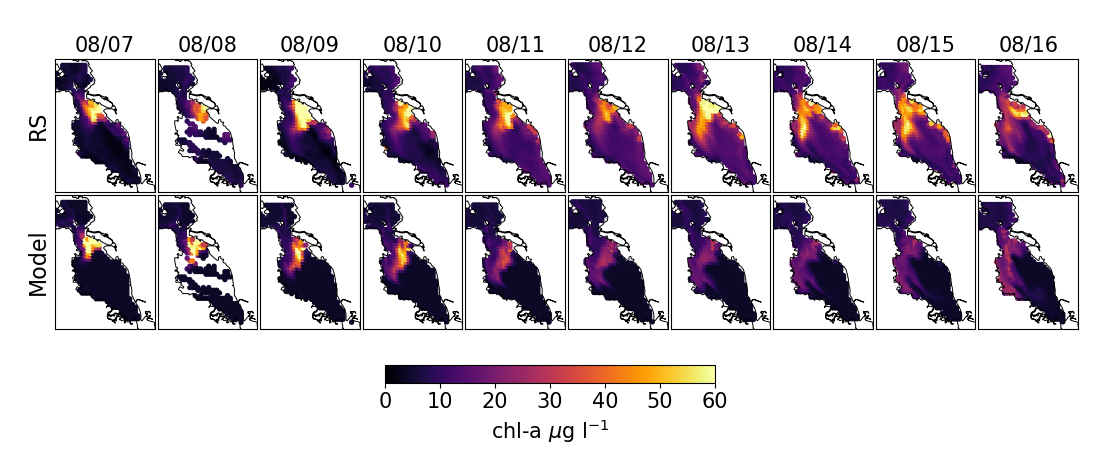

In [31]:
utils.add_to(tuner)(fig_last_eval_dense)

tuner.fig_last_eval_dense(cmap='inferno') ;

In [13]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='alameda'][0]
tuner_6j=FitLagrangianToRS(group=tg,train_tidxs=[73,97,121,145,169,193,217,241,265,289], downsample=3)
tuner_6j.tune(minimize_kw=dict(method='Powell'))
#solveNP(thresh=0.010,c0=1.179,kprod=1.874,N0=35.000,Nsat=5.000,kmort=0.069,Isat=5.560,background=8.763) err=10.18 in 0.802s

solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.64 in 0.052s
solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.64 in 0.723s
solveNP(thresh=0.010,c0=2.219,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=13.09 in 0.046s
solveNP(thresh=0.010,c0=3.281,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.62 in 0.045s
solveNP(thresh=0.010,c0=3.938,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.90 in 0.045s
solveNP(thresh=0.010,c0=3.193,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.62 in 0.045s
solveNP(thresh=0.010,c0=3.194,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.62 in 0.049s
solveNP(thresh=0.010,c0=3.194,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.62 in 0.046s


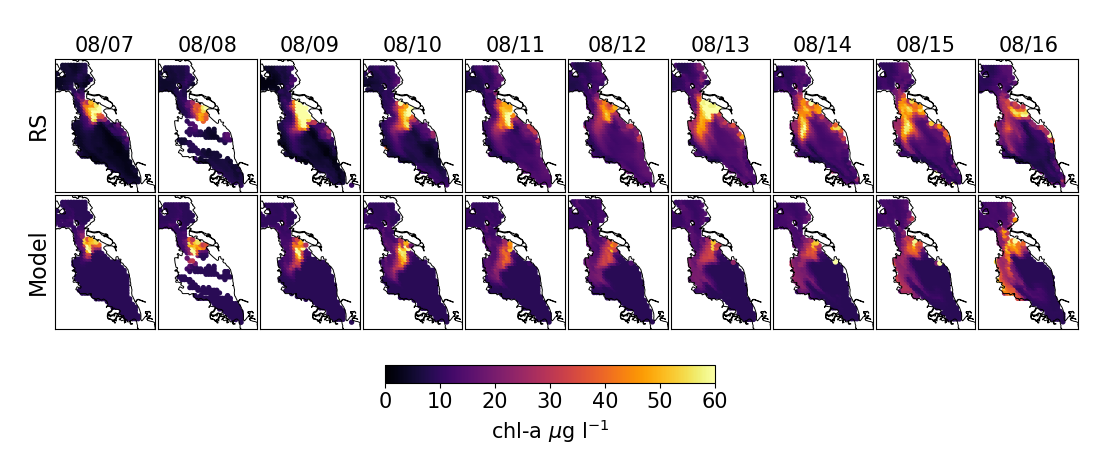

In [32]:
utils.add_to(tuner_6j)(fig_last_eval_dense)
tuner_6j.fig_last_eval_dense(cmap='inferno') ;

In [14]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==0.0 and t.initial=='alameda'][0]
tuner_0=FitLagrangianToRS(group=tg,train_tidxs=[73,97,121,145,169,193,217,241,265,289], downsample=3)
tuner_0.tune(minimize_kw=dict(method='Powell'))
# solveNP(thresh=0.010,c0=1.610,kprod=1.946,N0=35.000,Nsat=5.000,kmort=0.098,Isat=5.061,background=10.887) err=10.27 in 0.789s


solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=13.15 in 5.071s
solveNP(thresh=0.010,c0=3.000,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=13.15 in 0.933s
solveNP(thresh=0.010,c0=2.219,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=13.86 in 0.047s
solveNP(thresh=0.010,c0=3.281,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.96 in 0.047s
solveNP(thresh=0.010,c0=3.938,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.68 in 0.045s
solveNP(thresh=0.010,c0=4.529,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.61 in 0.049s
solveNP(thresh=0.010,c0=4.454,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.61 in 0.046s
solveNP(thresh=0.010,c0=4.450,kprod=1.000,N0=35.000,Nsat=0.500,kmort=0.050,Isat=10.000,background=4.000) err=12.61 in 0.045s


Other Groups
--

In [90]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912j and t.initial=='southbay'][0]
tuner=FitLagrangianToRS(group=tg)
minimize(cost, vec0, (tuner,), method='Powell', bounds=bounds)

kLight: 24146 missing values, thresh=0.01
kLight: 12342 missing values, thresh=0.01
kLight: 7797 missing values, thresh=0.01
kLight: 5424 missing values, thresh=0.01
solveNP({}) err=50.59 in 2.250s
kLight: 24146 missing values, thresh=0.01
kLight: 12342 missing values, thresh=0.01
kLight: 7797 missing values, thresh=0.01
kLight: 5424 missing values, thresh=0.01
solveNP({'c0': 3.0, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=50.59 in 3.272s
solveNP({'c0': 2.218847050625473, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=50.15 in 0.788s
solveNP({'c0': 3.2811529493745266, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=50.74 in 3.049s
solveNP({'c0': 1.5623058987490537, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=49.81 in 2.563s
solveNP({'c0': 1.1565411518764197, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=49.58 in 2.70

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.056426694196574
       x: [ 4.456e+00  4.226e-01  7.230e-04  1.218e+01  9.214e+00
            1.883e+00]
     nit: 6
   direc: [[ 4.416e-01 -1.066e-01 ... -2.451e-01  6.362e-06]
           [ 4.814e-01 -2.444e-02 ... -7.628e-01  3.212e-01]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-2.001e-01  1.470e-02 ...  4.072e-01 -1.619e+00]]
    nfev: 670

In [91]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==0.0 and t.initial=='southbay'][0]
tuner=FitLagrangianToRS(group=tg)
minimize(cost, vec0, (tuner,), method='Powell', bounds=bounds)

kLight: 24458 missing values, thresh=0.01
kLight: 12468 missing values, thresh=0.01
kLight: 7892 missing values, thresh=0.01
kLight: 5526 missing values, thresh=0.01
solveNP({}) err=51.60 in 1.738s
kLight: 24458 missing values, thresh=0.01
kLight: 12468 missing values, thresh=0.01
kLight: 7892 missing values, thresh=0.01
kLight: 5526 missing values, thresh=0.01
solveNP({'c0': 3.0, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=51.60 in 1.401s
solveNP({'c0': 2.218847050625473, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=51.52 in 3.030s
solveNP({'c0': 3.2811529493745266, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=51.66 in 1.784s
solveNP({'c0': 1.5623058987490537, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=51.40 in 2.193s
solveNP({'c0': 1.1565411518764197, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=51.36 in 1.34

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 47.41783841795517
       x: [ 5.000e+00  5.450e-01  7.951e-07  3.460e+01  1.054e+01
            4.996e+00]
     nit: 8
   direc: [[ 2.888e-01  3.636e-02 ... -1.332e+00 -6.593e-02]
           [-9.310e-08  5.536e-09 ...  1.015e-07 -1.686e-07]
           ...
           [-1.610e-05  1.899e-06 ...  2.144e-05  9.864e-07]
           [-9.680e-06  7.238e-07 ... -3.000e-06 -2.134e-07]]
    nfev: 1247

In [92]:
tg = [t for t in tracer_groups if t.tag=='v13' and t.swim==6.912 and t.initial=='southbay'][0]
tuner=FitLagrangianToRS(group=tg)
minimize(cost, vec0, (tuner,), method='Powell', bounds=bounds)

kLight: 24083 missing values, thresh=0.01
kLight: 12571 missing values, thresh=0.01
kLight: 8109 missing values, thresh=0.01
kLight: 5769 missing values, thresh=0.01
solveNP({}) err=50.48 in 1.874s
kLight: 24083 missing values, thresh=0.01
kLight: 12571 missing values, thresh=0.01
kLight: 8109 missing values, thresh=0.01
kLight: 5769 missing values, thresh=0.01
solveNP({'c0': 3.0, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=50.48 in 1.367s
solveNP({'c0': 2.218847050625473, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=49.95 in 1.953s
solveNP({'c0': 3.2811529493745266, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=50.74 in 2.257s
solveNP({'c0': 1.5623058987490537, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=49.64 in 2.968s
solveNP({'c0': 1.1565411518764197, 'kprod': 1.0, 'kmort': 0.05, 'Isat': 10.0, 'background': 4.0, 'Nsat': 0.5}) err=49.43 in 1.20

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 45.67237116731109
       x: [ 1.421e+00  5.443e-01  4.353e-03  1.177e+01  1.341e+01
            6.387e-01]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 458